In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import warnings
from colorama import Fore, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
import lightgbm
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import catboost

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [2]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    def top_four_percent_captured(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [3]:
CFG = {
    'num_folds': 5,


    'catboost': {
        'depth': 6,
        'iterations': 3000,
    },

    'make_submit': True,
    'seed': 777
}

In [4]:
features_avg = ['B_1', 'B_11', 'B_16', 'B_17', 'B_18', 'B_2', 'B_20',
                'B_28', 'B_3', 'B_4', 'B_5', 'B_7', 'B_9', 'D_112',
                'D_121', 'D_141', 'D_39', 'D_41', 'D_42', 'D_43',
                'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 
                'D_50', 'D_51', 'D_53', 'D_54', 'D_56', 'D_58', 
                'D_59', 'D_60', 'D_91', 'P_2', 'P_3', 'R_1', 'R_2', 
                'R_27', 'R_3', 'R_7', 'S_11', 'S_26', 'S_3', 'S_5']
features_last = ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_15', 'B_16',
                 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_22', 'B_23',
                 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3',
                 'B_32', 'B_33', 'B_36', 'B_38', 'B_39', 'B_4', 'B_40',
                 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9',
                 'D_102', 'D_103', 'D_105', 'D_106', 'D_107', 'D_109',
                 'D_112', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120',
                 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 
                 'D_129', 'D_132', 'D_133', 'D_135', 'D_136', 'D_137', 
                 'D_140', 'D_141', 'D_143', 'D_145', 'D_39', 'D_41',
                 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48',
                 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55',
                 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63',
                 'D_64', 'D_66', 'D_70', 'D_72', 'D_73', 'D_74', 'D_75',
                 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_82', 'D_83',
                 'D_84', 'D_86', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96',
                 'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_12', 'R_13',
                 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 
                 'R_21', 'R_22', 'R_24', 'R_25', 'R_26', 'R_27', 'R_3',
                 'R_4', 'R_5', 'R_7', 'R_8', 'R_9', 'S_11', 'S_12',
                 'S_13', 'S_15', 'S_17', 'S_20', 'S_22', 'S_23', 
                 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6',
                 'S_7', 'S_8', 'S_9']
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [5]:
def make_categorical_features(df):
    cat_df = pd.DataFrame([], index=df['customer_ID'].unique())
    for feature in cat_features:
        cl_sv = pd.pivot_table(df, index='customer_ID', columns=feature, values = 'P_2', aggfunc = 'count')
        cl_sv['summs'] = cl_sv.sum(axis=1)
        for i in cl_sv.columns[:-1]:
            cl_sv[i] = cl_sv[i] / cl_sv['summs']
        cl_sv.columns = [feature + '_'+ str(i) + '_count' for i in cl_sv.columns]
        cat_df = cat_df.merge(cl_sv, how='left', left_index=True, right_index=True)
    cat_df = cat_df.sort_index().fillna(0)
    del cl_sv
    return cat_df


def get_data(path, train=False):
    data = pd.read_feather(path)
    cat_df = make_categorical_features(data)
    if 'target' in data.columns:
        main_data = data.drop('target', axis=1).groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()
    else:
        main_data = data.groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()
    main_data.columns = [f'{x[0]}_{x[1]}' for x in main_data.columns]
    cid = pd.Categorical(data.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1))
    if train: target = data.loc[last, 'target']
    df_avg = data[features_avg].groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in features_avg})
    data = data.loc[last, features_last].rename(columns={f: f"{f}_last" for f in features_last}).set_index(np.asarray(cid[last]))
    data = pd.concat([data, df_avg, cat_df, main_data], axis=1)
    cat_features = data.select_dtypes(['category']).columns.tolist()
    data[cat_features] = data[cat_features].astype('str')

    if train: return data, target
    else: return data, cat_features

train_data, target = get_data('data/train_data.ftr', train=True)
test_data, cat_features = get_data('data/test_data.ftr')

le_encoder = LabelEncoder()
for feature in cat_features:
    train_data[feature] = le_encoder.fit_transform(train_data[feature])
    test_data[feature] = le_encoder.transform(test_data[feature])

gc.collect()

/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_10245/1435474558.py:19: FutureWarning: ['S_2', 'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  main_data = data.drop('target', axis=1).groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()
/var/folders/bb/jzxxldrn52l0stzqmszjx6840000gn/T/ipykernel_10245/1435474558.py:21: FutureWarning: ['S_2', 'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  main_data = data.groupby('customer_ID').agg(['mean', 'median', 'std', 'min', 'max']).sort_index()


0

In [6]:
features = [f for f in train_data.columns if f not in ('customer_ID', 'target')]

not_found = []
for feature in features:
    if feature not in test_data.columns:
        not_found.append(feature)
test_data = test_data.assign(**dict.fromkeys(not_found, 0))

score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=CFG['num_folds'], random_state=CFG['seed'], shuffle=True)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr, X_va = train_data.iloc[idx_tr][features], train_data.iloc[idx_va][features]
    y_tr, y_va = target.iloc[idx_tr], target.iloc[idx_va]

    model = CatBoostClassifier(
        depth=CFG['catboost']['depth'],
        iterations=CFG['catboost']['iterations'],
        # learning_rate=0.05,
        custom_metric=['AUC'],
        random_seed=CFG['seed'],
        thread_count=6,
        early_stopping_rounds=300
    )
    model.fit(Pool(X_tr, y_tr, cat_features=cat_features),
              eval_set=Pool(X_va, y_va, cat_features=cat_features),
              verbose=100)

    y_va_pred = model.predict_proba(Pool(X_va, cat_features=cat_features))[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)

    y_pred_list.append(model.predict_proba(Pool(test_data[features], cat_features=cat_features))[:,1])
    gc.collect()

print(f"{Fore.RED}{Style.BRIGHT}OOF Score:   {np.mean(score_list):.5f}{Style.RESET_ALL}")

Learning rate set to 0.084503
0:	learn: 0.5974670	test: 0.5969978	best: 0.5969978 (0)	total: 470ms	remaining: 23m 28s
100:	learn: 0.2258553	test: 0.2257133	best: 0.2257133 (100)	total: 31.1s	remaining: 14m 53s
200:	learn: 0.2184890	test: 0.2210481	best: 0.2210481 (200)	total: 1m 1s	remaining: 14m 12s
300:	learn: 0.2134019	test: 0.2192581	best: 0.2192581 (300)	total: 1m 30s	remaining: 13m 32s
400:	learn: 0.2091622	test: 0.2184193	best: 0.2184172 (398)	total: 1m 59s	remaining: 12m 53s
500:	learn: 0.2053301	test: 0.2178709	best: 0.2178709 (500)	total: 2m 28s	remaining: 12m 19s
600:	learn: 0.2018128	test: 0.2175722	best: 0.2175659 (599)	total: 2m 56s	remaining: 11m 44s
700:	learn: 0.1984235	test: 0.2173562	best: 0.2173409 (697)	total: 3m 25s	remaining: 11m 13s
800:	learn: 0.1952416	test: 0.2171884	best: 0.2171884 (800)	total: 3m 53s	remaining: 10m 41s
900:	learn: 0.1921089	test: 0.2170253	best: 0.2170253 (900)	total: 4m 22s	remaining: 10m 12s
1000:	learn: 0.1890378	test: 0.2170119	best: 0.

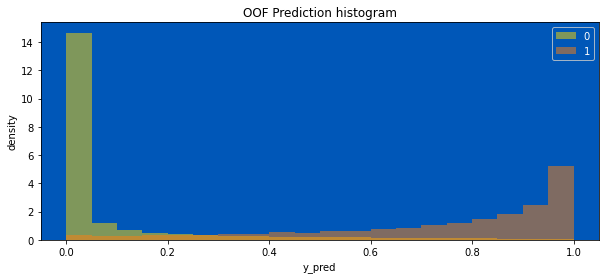

In [7]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

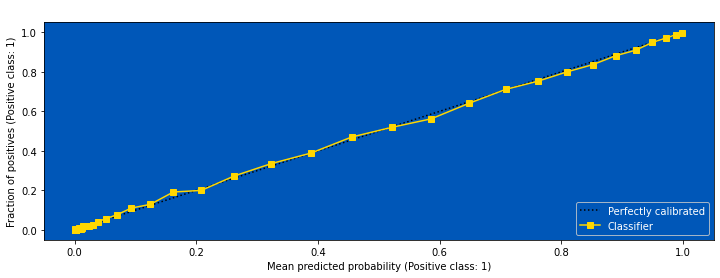

In [8]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [9]:
if CFG['make_submit']:
    sub = pd.DataFrame({'customer_ID': test_data.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission_v4.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.030323
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001715
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.036270
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.188898
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.830164
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.011932
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.787357
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.403643
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.273249
